# Analyzing NYC High School Data

## Introduction
> The SAT is a standardized test widely used for college admissions in the United States. It is composed of three sections: critical reading, writting, and mathematics. In this project, we will be analyzing the average SAT scores of high schools from the five boroughs of New York City. These borouhgs are very diverese and differ from eachother greatly. We will expore how the factors in each neighborhood influence the average SAT score of high schools. We will be specifically looking at the correlations and relationships between average SAT scores and demographic factors such as high school racial proportions. The aim of this project is to demonstrate how we can compile data from different sources into one unified dataset and explore the correlations between factors. The first part of this notebook will focus on combining, cleaning, and preparing the different datasets into a singular unfied dataset. The second section will focus on exploring the correlations and relationships between SAT Scores and a wide variety of factors.

In [1]:
# Importing the Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [2]:
# Loading the files into a dictionary
files = ["ap_2010.csv", "class_size.csv", "demographics.csv", "graduation.csv", "hs_directory.csv", "sat_results.csv", "survey_all.txt", "survey_d75.txt"]

data_files = {}

for file in files:
    if file.split(".")[1] == "csv":
        loaded_file = pd.read_csv("/Users/omarstinner/Data Files/Python Projects/Files/Guided Project - Analyzing NYC High School Data/{}".format(file))
        data_files[file.split(".")[0]] = loaded_file
    else:
        loaded_file = pd.read_csv("/Users/omarstinner/Data Files/Python Projects/Files/Guided Project - Analyzing NYC High School Data/{}".format(file), delimiter = "\t", encoding = "windows-1252")
        data_files[file.split(".")[0]] = loaded_file
        
# Combining the survey files together and adding it to "data_files"
survey = pd.concat([data_files["survey_all"], data_files["survey_d75"]], axis = 0)

# Selecting the columns we want from the combined dataset and renming the capitalizing the "DBN" column
survey_fields = ["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
survey = survey.loc[:, survey_fields] 
survey.rename(columns = {"dbn" : "DBN"}, inplace = True)

# Adding the combined survey to the data_files dictionary
data_files["survey"] = survey

# Capitalizing the name of the "dbn" column
data_files["hs_directory"].rename(columns = {"dbn" : "DBN"}, inplace = True)

# Deleting the singular survey files
del data_files["survey_all"]
del data_files["survey_d75"]

## Part 1: Combining, Cleaning, and Preparing The Data

In [3]:
# Creating a "dbn" column in "class_size" file
data_files["class_size"]["DBN"] = data_files["class_size"].apply(lambda x : "0" + str(x["CSD"]) + x["SCHOOL CODE"] 
                                                                 if len(str(x["CSD"])) <= 1 
                                                                 else str(x["CSD"]) + x["SCHOOL CODE"], axis = 1)

In [4]:
# Converting columns in "sat_scores" to a numeric datatype - nede to use coerce to bypass the "s" values and replace them with null values
for col in data_files["sat_results"].iloc[:, 2:].columns:
    data_files["sat_results"][col] = pd.to_numeric(data_files["sat_results"][col], errors = "coerce")

# Creating a new column that sums up all the aveerage scors fore each section to form a combined total score
data_files["sat_results"]["sat_score"] = data_files["sat_results"].apply(lambda x : x.iloc[3] + 
                                                                                    x.iloc[4] + 
                                                                                    x.iloc[5], axis = 1)

# Extracting the longitude and latitude from the "Location 1" column of the "hs_directory" data file and putting them in seperate columns
data_files["hs_directory"]["latitude"] = data_files["hs_directory"]["Location 1"].apply(lambda x : re.findall("\(.+, .+\)", x)[0].split(",")[0].replace("(", ""))
data_files["hs_directory"]["longitude"] = data_files["hs_directory"]["Location 1"].apply(lambda x : re.findall("\(.+, .+\)", x)[0].split(",")[1].replace(")", ""))

# Converting the datatype to numeric
data_files["hs_directory"]["latitude"] = pd.to_numeric(data_files["hs_directory"]["latitude"], errors = "coerce")
data_files["hs_directory"]["longitude"] = pd.to_numeric(data_files["hs_directory"]["longitude"], errors = "coerce")

In [5]:
# Selecting rows where GRADE = "09-12" and where "PROGRAM TYPE" = "GEN ED", because we're only interested in High School Data
data_files["class_size"] = data_files["class_size"][(data_files["class_size"]["GRADE "] == "09-12") & (data_files["class_size"]["PROGRAM TYPE"] == "GEN ED")]

# Only keeping the numerical columns and finding the avearges of those column for all grades of highschool
data_files["class_size"] = data_files["class_size"].groupby("DBN").agg(np.mean)

# Returning the Index to its orignial index (it was the dbn before, beacuse we used groupby, so now we return it)
data_files["class_size"].reset_index(inplace = True)

# Only interested in the school year 2011-2012 as this analysis focuses on that year? - find that out in prevois lessons before the project
data_files["demographics"] = data_files["demographics"][data_files["demographics"]["schoolyear"] == 20112012]

# Find out from previous lessons why we are selecting 2006 and "Total Cohort"
data_files["graduation"] = data_files["graduation"][(data_files["graduation"]["Cohort"] == "2006") & (data_files["graduation"]["Demographic"] == "Total Cohort")]


In [6]:
# Convertitn supposed to be numericc olumsn to numeri columns
for col in data_files["ap_2010"].iloc[:, 2:]:
    data_files["ap_2010"][col] = pd.to_numeric(data_files["ap_2010"][col], errors = "coerce")

In [7]:
# Combining the all the dataframes into one dataframe
combined = data_files["sat_results"]

def combiner(to_combine, merge_type):
    global combined
    for file in to_combine:
        combined = combined.merge(data_files[file], on = "DBN", how = merge_type)
        
combiner(["ap_2010", "graduation"], "left")
combiner(["class_size", "demographics", "survey", "hs_directory"], "inner")

> We first left joined the "ap_2010" and "graduation", because we are considering the information in these datasets extra and not mandatory for our analysis. We are inner joining "class_size", "demographics", "survey", and "hs_directory" because they are essential to explore the purpose of this project which is investigating the relationship between SAT scores and demographic factors.

In [8]:
# adding a school district column
combined["school_dist"] = combined["DBN"].apply(lambda x : x[:2])

In [9]:
correlations = combined.corr()
correlations["sat_score"]

Num of SAT Test Takers                  0.485338
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.619152
Total Exams Taken                       0.608719
Number of Exams with scores 3 4 or 5    0.612911
Total Cohort                            0.332066
CSD                                     0.044940
NUMBER OF STUDENTS / SEATS FILLED       0.400730
NUMBER OF SECTIONS                      0.368859
AVERAGE CLASS SIZE                      0.411199
SIZE OF SMALLEST CLASS                  0.272326
SIZE OF LARGEST CLASS                   0.343992
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
frl_percent                            -0.751400
total_enrollment                        0.372790
ell_num                                -0.154844
ell_percent         

In [10]:
# removing "dbn" column feom survey_fields as it has no numerical value
survey_fields.remove("dbn")

## Part 2: Analyzing the Data

### SAT Score vs. Survey Fields

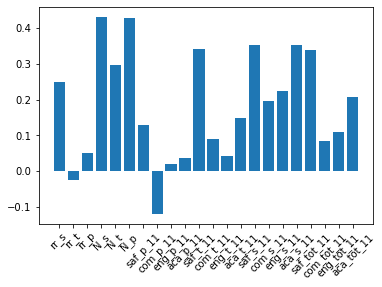

In [11]:
# Finding the correlations between sat_scores and the all the numerical survey fields
plt.bar(correlations["sat_score"][survey_fields].index, correlations["sat_score"][survey_fields])
plt.xticks(rotation = 45)
plt.show()

> Looking at the above correlations between "sat_score" and all the survey fields, we see that such fields are at most moderately correlated with "sat_score", with the strongest correlation only being slightly above an r score of 0.4 - belonging to "N_s": The number of student respondents. This similar correlation is also seen with "N_p": The number of parent respondents. This suggests that schools whose students and parents fill out response surveys are more likely to have higher average SAT scores. Filling out a response survey can be an indication of good performance on the SAT as it is typically natural that someone will give feedback if he/she performs well on an exam than if he/she doesn't. This same conclusion is also expressed in the correlation between "rr_s": student response rate and "sat_score". The schools that have a higher proportion of students who completed the survey see an increase in average "sat_score". The correlations between "sat_score" and "saf_t_11", "saf_s_11" (How teachers and student perceived safety) are around 0.3. These correlations are quite self-explanatory as a safe environment is more likely to facilitate SAT success. It is interesting to see how  the correlations of academic standards ("aca_s_11", "aca_t_11", and "aca_p_11"), with "sat_score" differ from the different groups of people. Students’ perception of academic standards ("ac_s_11") has the highest correlation between the three. This seems logical as an SAT score is mostly dependant on the student, while the parents and teacher act as the supporting cast. This means that their perception has the strongest influence on how they perform on the SAT.

### SAT Score vs. Safety

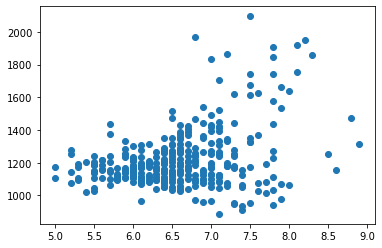

boro
Manhattan        6.836364
Queens           6.721875
Bronx            6.606522
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

In [12]:
# Exploring Safety
plt.scatter(combined["saf_s_11"], combined["sat_score"])
plt.show()

combined.groupby("boro")["saf_s_11"].mean().sort_values(ascending = False)

> Exploring the relationship between safety is quite interesting as a safety score is a non-academic factor that can heavily influence a student’s performance in school. We can see in the scatter plot above that the only schools that perform exceptionally well on the SAT are those where students report a safety score of 7.5 and above. Schools that perform poorly on the SAT score usually tend to be in areas that are less safe as reported by their students. Looking at the average safety scores of students for each neighborhood, we see that Brooklyn receives the lowest average score of 6.37, while Manhattan, the "safest" neighborhood, has a score of 6.83. These scores make sense as social-economic statuses of each neighborhood are somewhat representative of their safety scores. Manhattan is a wealthier neighborhood, meaning that they probably have higher safety standards and hence higher average SAT scores.

### SAT Score vs. Race

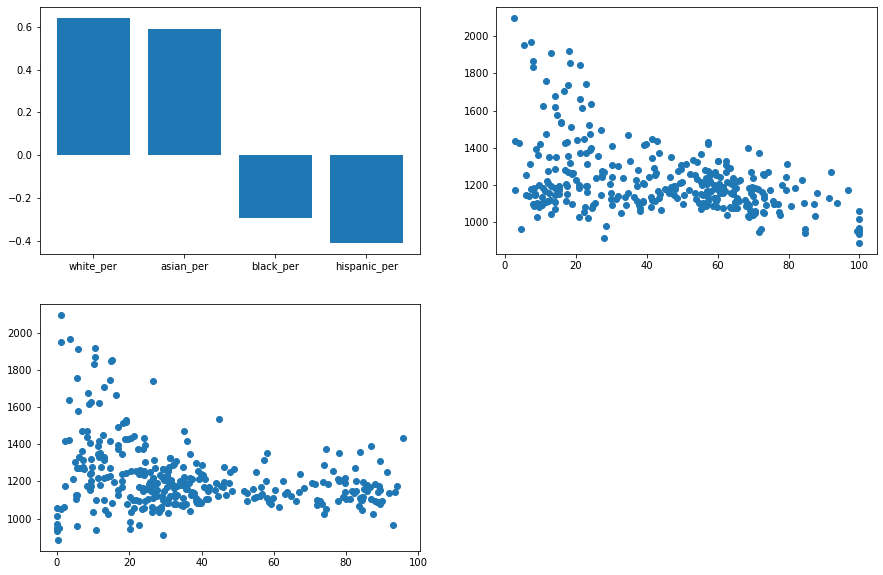

,white_per,asian_per,black_per,hispanic_per
boro,,,,
Bronx,39.60,40.100000,7.050000,12.600000
Brooklyn,21.30,60.300000,10.200000,7.900000
Manhattan,33.20,41.133333,10.433333,13.933333
Queens,15.65,64.950000,8.200000,10.400000
Staten Island,61.30,31.800000,1.100000,5.300000


44                                MANHATTAN BRIDGES HIGH SCHOOL
82             WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS
125                         ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                       INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176            PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                                   MULTICULTURAL HIGH SCHOOL
286                      PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

37                                  STUYVESANT HIGH SCHOOL
151                           BRONX HIGH SCHOOL OF SCIENCE
187                         BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE
356                    STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [13]:
# Exploring racial diffences in SAT Score
fig1 = plt.figure(figsize = (15, 10))
gs1 = gs.GridSpec(nrows = 2, ncols = 2)

ax1 = plt.subplot(gs1[0,0])
ax1.bar(combined.corr()["sat_score"][["white_per", "asian_per", "black_per", "hispanic_per"]].index, combined.corr()["sat_score"][["white_per", "asian_per", "black_per", "hispanic_per"]])

ax2 = plt.subplot(gs1[0,1])
ax2.scatter(combined["hispanic_per"], combined["sat_score"])

ax3 = plt.subplot(gs1[1,0])
ax3.scatter(combined["black_per"], combined["sat_score"])

plt.show()

display(combined[combined["sat_score"] >= 1800].groupby("boro")[["white_per", "asian_per", "black_per", "hispanic_per"]].mean())
display(combined[combined["hispanic_per"] >= 95]["SCHOOL NAME"])
display(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] >= 1800)]["SCHOOL NAME"])

> Above, we see that as the proportion of white or Asian students increases, the average SAT score also increases. While increased proportions of black or hispanic students leads to a lower average SAT scores. This could suggest that the education received in poorer schools is of very low quality and such schools are in communities that are more black and hispanic. We also looked at schools that had an average SAT scores of at least 1600. The results were coherent with the correlation graph, where we see higher proportions of white and asian students in schools that perform better on the SAT. After further exploring schools with high and low proportions of hispanic students, we can see that schools with high proportions of hispanic students are those that are more "international" that are probably populated woth students where english is their second language - this could be the reason for poor SAT scores. On the other hand, the schools that have low proportions of hispanic students and have a high average SAT scores, tend to be more STEM-related schools centered around technical fields such as Science and Math.

### SAT Score vs. Gender

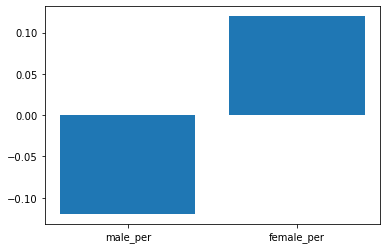

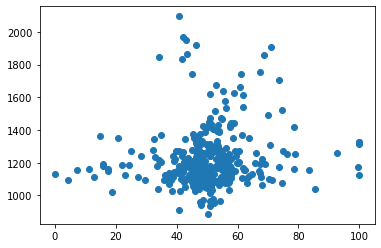

Manhattan    19
Brooklyn     13
Bronx         6
Queens        4
Name: boro, dtype: int64

In [14]:
# Gender differnces in SAT Score
plt.bar(combined.corr()["sat_score"][["male_per", "female_per"]].index, combined.corr()["sat_score"][["male_per", "female_per"]])
plt.show()

plt.scatter(combined["female_per"], combined["sat_score"])
plt.show()

combined[(combined["female_per"] >= 60) & (combined["female_per"] <= 80)]["boro"].value_counts()

> We see that there is no strong correlation between gender and SAT scores, although females tend to perform better ever so slightly. However, when we further explore the relationship between "female_per" and "sat_score" there are some High schools that have a high proportion of female students. Interestingly, The majority of these High schools are located in Manhattan.

### SAT Score vs. AP Test Takers

0.7299920463969354


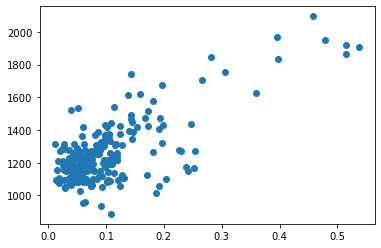

37                                  STUYVESANT HIGH SCHOOL
155      HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
302                            TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE
356                    STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [15]:
# Does the proptooin of AP Test takers influence the avergae SAT score of a high school.
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

print(combined.corr()["sat_score"]["ap_per"])

plt.scatter(combined["ap_per"], combined["sat_score"])
plt.show()

combined[(combined["sat_score"] >= 1800) & (combined["ap_per"] >= 0.4)]["SCHOOL NAME"]

> AP courses and exams have the same rigor as introductory university courses. To some extent, this can indicate the level of intellectuality at a school. We see this notion displayed through the high correlation score of 0.72 between "sat_score" and our newly formed variable "ap_per". The higher the proportion of AP Test takers in a High school, the higher the average "sat_score" of the high school.

### SAT Scores vs. Class Size

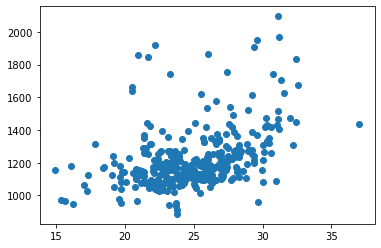

37             STUYVESANT HIGH SCHOOL
151      BRONX HIGH SCHOOL OF SCIENCE
187    BROOKLYN TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [16]:
# we can compare the avegra gclass sizes tha tare big and scroes between the good and bad neighborrohods
plt.scatter(combined["AVERAGE CLASS SIZE"], combined["sat_score"])
plt.show()


combined.corr()["sat_score"]["AVERAGE CLASS SIZE"]

combined[(combined["AVERAGE CLASS SIZE"] >= 30) & (combined["sat_score"] >= 1800)]["SCHOOL NAME"]

> It is interesting to see that there is a positive correlation between "sat_score" and "AVERAGE CLASS SIZE", as one would expect that students in a smaller class would receive more attention, which would lead to a higher average SAT score for a high school. After examining schools that had large class sizes (30 and above) and high average SAT scores (1800 and above), we see that these schools are more STEM-related and academically more technical.

## Conclusion
> Throughout this analysis, we have explored the different factors that influence the average SAT scores of high schools. We concluded that High schools that had high rates of student and parents survey responses showed increased average SAT scores. This finding is coherent with human nature as students are more inclined to participate in a survey if they performed well on an SAT exam. We also discovered that schools with higher perceived safety scores also performed better than those with lower scores. Such higher scores were more common amongst high schools in the Manhattan borough. Indeed, a safer environment facilitates success. Of all the races, hispanic students tend to perform the worst on the SATs out of all the races - this could be due to the fact that english is not their native language and so their performance on the english language-based exam is justified. We found out that gender was not a determinant of SAT scores. AS expected High schools that had a higher proportion of their students take AP courses and exams tended to have higher average SAT Scores. Taking AP classes is an indicator of academic intellect, hence an increased proportion of AP test-takers can highly translate to a high average SAT Score. Interestingly, "class_size" had a positive correlation with "sat_score". Logically, speaking a smaller class size should lead to a higher average SAT scores, however, this was not the case in our findings. The schools that had large class sizes and high average SAT Scores were usually highly technical schools, which could explain their high SAT Scores, regardless of their class size.

In [17]:
%%html
<style>
.nbviewer div.output_area {
  overflow-y: auto;
  max-height: 400px;
}
</style>